# Лабораторна робота №3: Регресія та оцінки її точності

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error

### 1. Завантажте датасет `data.csv` та візуалізуйте дані за допомогою діаграми розсіювання

На діаграмі розсіювання через велику кількість значень точки можуть "зливатись", тому можете використовувати атрибут методу `.scatter(..., s=0.5)`, який відповідає за маштабування точок на діаграмі.

      x           y
0  24.0  164.648356
1  50.0  242.393389
2  15.0  151.655969
3  38.0  209.759194
4  87.0  361.866952


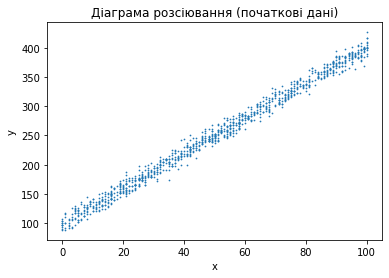

In [3]:
data = pd.read_csv('data.csv')
print(data.head())

plt.scatter(data['x'], data['y'], s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Діаграма розсіювання (початкові дані)')
plt.show()



### 2. Нормалізуйте значення $x$ та $y$ з датасету, використовуючи стандартизовану оцінку

[Стандартизована оцінка](https://uk.wikipedia.org/wiki/Стандартизована_оцінка) розраховується за наступною формулою: $ z = \frac{x - \mu}{\sigma} $, де $\mu$ - [середнє значення](https://uk.wikipedia.org/wiki/Середнє_значення) вибірки, а $\sigma$ - [стандартне відхилення](https://uk.wikipedia.org/wiki/Стандартне_відхилення).

Візуалізуйте нормалізовані дані.

      x           y  x_normalized  y_normalized
0  24.0  164.648356     -0.912609     -0.989042
1  50.0  242.393389     -0.010111     -0.098158
2  15.0  151.655969     -1.225012     -1.137922
3  38.0  209.759194     -0.426649     -0.472115
4  87.0  361.866952      1.274213      1.270894


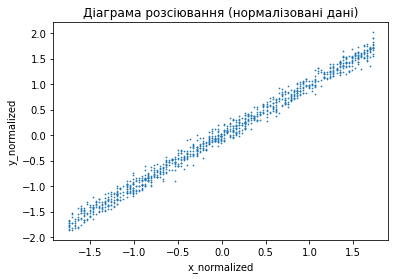

In [4]:
x_mean = data['x'].mean()
x_std = data['x'].std()
data['x_normalized'] = (data['x'] - x_mean) / x_std

y_mean = data['y'].mean()
y_std = data['y'].std()
data['y_normalized'] = (data['y'] - y_mean) / y_std

print(data.head())

plt.scatter(data['x_normalized'], data['y_normalized'], s=0.5)
plt.xlabel('x_normalized')
plt.ylabel('y_normalized')
plt.title('Діаграма розсіювання (нормалізовані дані)')
plt.show()

### 3. Розбийте датасет на вибірки для тренування та тестування

In [5]:
from sklearn.model_selection import train_test_split

# Виокремлюємо нормалізовані ознаки та цільову змінну
X = data[['x_normalized']]
y = data['y_normalized']

# Розбиваємо дані на тренувальну та тестову вибірки у співвідношенні 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Розмір тренувальної вибірки:", X_train.shape)
print("Розмір тестової вибірки:", X_test.shape)

Розмір тренувальної вибірки: (799, 1)
Розмір тестової вибірки: (200, 1)


### 4. Реалізуйте алгоритм лінійної регресії, який використовує градієнтний спуск для мінімізації функції втрат

**Модель:** $ f_{\beta_{0},\beta_{1}}(x) = \beta_{0} + \beta_{1} * x $

**Функція витрат:** $J(\beta_{0},\beta_{1}) = \frac{1}{2m} \sum_{i=1}^{m}(f_{\beta_{0},\beta_{1}}(x^{(i)})-y^{(i)})^2 $

**Алгоритм градієнтного спуску:**

$\text{виконувати, доки } J(\beta_{0},\beta_{1}) \text{ не мінімізується \{}$

$\qquad\beta_{0} = \beta_{0} - \alpha \frac{\partial}{\partial\beta_{0}}J(\beta_{0},\beta_{1})$

$\qquad\beta_{1} = \beta_{1} - \alpha \frac{\partial}{\partial\beta_{1}}J(\beta_{0},\beta_{1})$

$\text{\}}$

**Де похідні:**

$\frac{\partial}{\partial\beta_{0}}J(\beta_{0},\beta_{1}) = \frac{1}{m}\sum_{i=1}^{m}(f_{\beta_{0},\beta_{1}}(x^{(i)})-y^{(i)}) $

$\frac{\partial}{\partial\beta_{1}}J(\beta_{0},\beta_{1}) = \frac{1}{m}\sum_{i=1}^{m}(f_{\beta_{0},\beta_{1}}(x^{(i)})-y^{(i)})*x^{(i)} $

У метод градієнтного спуску додайте зберігання значення функції витрат для кожного його кроку.

Для більш детального ознайомлення із алгоритмом лінійної регресії та градієнтного спуску можете звернутись до відео `#9` - `#20` зі [списку відтворення на YouTube каналу deeplearning.ai](https://www.youtube.com/playlist?list=PLkDaE6sCZn6FNC6YRfRQc_FbeQrF8BwGI). Тема лінійної регресії розкривається у відео `#9` - `#14`, а градієнтного спуску у відео `#15` - `#20`.

In [6]:
def cost_function(X, y, beta_0, beta_1):
    """
    Обчислює значення функції втрат (середньоквадратичної помилки).

    Args:
        X (numpy.ndarray): Масив значень ознаки (тренувальна вибірка).
        y (numpy.ndarray): Масив значень цільової змінної (тренувальна вибірка).
        beta_0 (float): Поточне значення параметра beta_0 (зсув).
        beta_1 (float): Поточне значення параметра beta_1 (нахил).

    Returns:
        float: Значення функції втрат.
    """
    m = len(y)
    predictions = beta_0 + beta_1 * X
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

def gradient_descent(X, y, learning_rate, iterations):
    """
    Реалізує алгоритм градієнтного спуску для навчання моделі лінійної регресії.

    Args:
        X (numpy.ndarray): Масив значень ознаки (тренувальна вибірка).
        y (numpy.ndarray): Масив значень цільової змінної (тренувальна вибірка).
        learning_rate (float): Швидкість навчання (альфа).
        iterations (int): Кількість ітерацій градієнтного спуску.

    Returns:
        tuple: Кортеж, що містить:
            - beta_0 (float): Оптимізоване значення параметра beta_0.
            - beta_1 (float): Оптимізоване значення параметра beta_1.
            - cost_history (list): Список значень функції втрат на кожній ітерації.
    """
    m = len(y)
    beta_0 = 0  # Ініціалізуємо beta_0 нулем
    beta_1 = 0  # Ініціалізуємо beta_1 нулем
    cost_history = []

    for i in range(iterations):
        # Обчислюємо передбачення на основі поточних параметрів
        predictions = beta_0 + beta_1 * X

        # Обчислюємо градієнти для beta_0 та beta_1
        db0 = (1 / m) * np.sum(predictions - y)
        db1 = (1 / m) * np.sum((predictions - y) * X)

        # Оновлюємо параметри за правилом градієнтного спуску
        beta_0 = beta_0 - learning_rate * db0
        beta_1 = beta_1 - learning_rate * db1

        # Обчислюємо та зберігаємо значення функції втрат на поточній ітерації
        cost = cost_function(X, y, beta_0, beta_1)
        cost_history.append(cost)

        if i % 100 == 0:  # Виводимо значення функції втрат кожні 100 ітерацій для контролю
            print(f"Ітерація {i}, Втрати: {cost}")

    return beta_0, beta_1, cost_history

# Встановлюємо гіперпараметри
learning_rate = 0.01
iterations = 1000

# Перетворюємо тренувальні дані у масиви NumPy
X_train_np = X_train['x_normalized'].values
y_train_np = y_train.values

# Запускаємо градієнтний спуск
trained_beta_0, trained_beta_1, cost_history = gradient_descent(X_train_np, y_train_np, learning_rate, iterations)

print("\nОптимізовані параметри:")
print(f"Beta_0: {trained_beta_0}")
print(f"Beta_1: {trained_beta_1}")

Ітерація 0, Втрати: 0.4959149969126544
Ітерація 100, Втрати: 0.06958262811827508
Ітерація 200, Втрати: 0.013360600055738815
Ітерація 300, Втрати: 0.005944390404380311
Ітерація 400, Втрати: 0.004965854911096888
Ітерація 500, Втрати: 0.004836705620447376
Ітерація 600, Втрати: 0.00481965539807871
Ітерація 700, Втрати: 0.004817403792446418
Ітерація 800, Втрати: 0.0048171063653787176
Ітерація 900, Втрати: 0.00481706706505645

Оптимізовані параметри:
Beta_0: -0.0025101416267546213
Beta_1: 0.9972117598761622


### 5. Візуалізуйте мінімізацію функції витрат $J(\beta_{0},\beta_{1})$

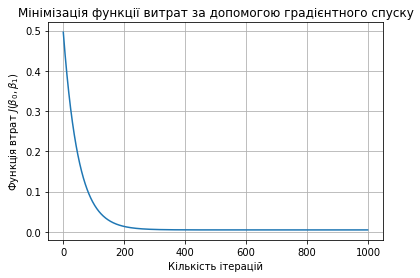

In [7]:
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Кількість ітерацій')
plt.ylabel('Функція втрат $J(\\beta_0, \\beta_1)$')
plt.title('Мінімізація функції витрат за допомогою градієнтного спуску')
plt.grid(True)
plt.show()

### 6. Візуалізуйте дані з датасету та пряму регресії на одній діаграмі

Для відображення даних з датасетів тренування та тестування використовуйте різні кольори.

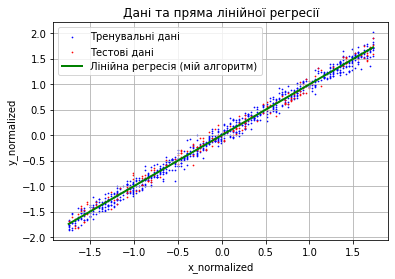

In [8]:
plt.scatter(X_train['x_normalized'], y_train, color='blue', label='Тренувальні дані', s=0.5)
plt.scatter(X_test['x_normalized'], y_test, color='red', label='Тестові дані', s=0.5)

# Генеруємо точки для лінії регресії
x_range = np.linspace(X['x_normalized'].min(), X['x_normalized'].max(), 100)
y_predicted = trained_beta_0 + trained_beta_1 * x_range

# Відображаємо лінію регресії
plt.plot(x_range, y_predicted, color='green', linewidth=2, label='Лінійна регресія (мій алгоритм)')

plt.xlabel('x_normalized')
plt.ylabel('y_normalized')
plt.title('Дані та пряма лінійної регресії')
plt.legend()
plt.grid(True)
plt.show()

### 7. Скористайтесь алгоритмом стохастичного градієнтного спуску з бібліотеки `sklearn` для отримання аналогічних параметів

Тепер за допомогою класу `SGDRegressor` з бібліотеки `sklearn` побудуйте аналогічну модель. Для тренування використовуйте ті самі дані, які ми використовували для алгоритму лінійної регресії.

Відобразіть датасет та пряму регресії з отриманої моделі.

Параметри моделі SGDRegressor:
Beta_0 (зсув): -0.0018979983599029077
Beta_1 (нахил): 0.9963934007712281


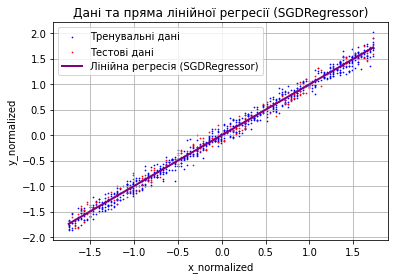

In [9]:
# Створюємо та навчаємо модель SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X_train, y_train)

# Отримуємо параметри моделі (коефіцієнт та зсув)
sklearn_beta_1 = sgd_reg.coef_[0]
sklearn_beta_0 = sgd_reg.intercept_[0]

print("Параметри моделі SGDRegressor:")
print(f"Beta_0 (зсув): {sklearn_beta_0}")
print(f"Beta_1 (нахил): {sklearn_beta_1}")

# Візуалізуємо дані та пряму регресії, отриману за допомогою SGDRegressor
plt.scatter(X_train['x_normalized'], y_train, color='blue', label='Тренувальні дані', s=0.5)
plt.scatter(X_test['x_normalized'], y_test, color='red', label='Тестові дані', s=0.5)

# Генеруємо точки для лінії регресії за допомогою параметрів sklearn
y_predicted_sklearn = sklearn_beta_0 + sklearn_beta_1 * x_range

# Відображаємо лінію регресії, отриману за допомогою SGDRegressor
plt.plot(x_range, y_predicted_sklearn, color='purple', linewidth=2, label='Лінійна регресія (SGDRegressor)')

plt.xlabel('x_normalized')
plt.ylabel('y_normalized')
plt.title('Дані та пряма лінійної регресії (SGDRegressor)')
plt.legend()
plt.grid(True)
plt.show()

### 8. Порівняйте значення $\beta_0$ та $\beta_1$ які Ви отримали в результаті роботи Вашого алгоритму, та алгоритму з бібліотеки `sklearn`

In [10]:
print("Порівняння параметрів:")
print(f"Наш алгоритм - Beta_0: {trained_beta_0:.4f}, Beta_1: {trained_beta_1:.4f}")
print(f"SGDRegressor - Beta_0: {sklearn_beta_0:.4f}, Beta_1: {sklearn_beta_1:.4f}")

Порівняння параметрів:
Наш алгоритм - Beta_0: -0.0025, Beta_1: 0.9972
SGDRegressor - Beta_0: -0.0019, Beta_1: 0.9964


### 9. Зробіть порівняння метрик $R^2$ та `MAE` для Вашого алгоритму та для алгоритму з бібліотеки `sklearn`

Для підрахунку метрик $R^2$ та `MAE` скористайтесь вибіркою з датасету _для тестування_.

$R^2$ - [коефіцієнт детермінації](https://uk.wikipedia.org/wiki/Коефіцієнт_детермінації), метод [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) з бібліотки `sklearn`.

`MAE` - [середня абсолютна похибка](https://en.wikipedia.org/wiki/Mean_absolute_error), метод [`mean_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) з бібліотки `sklearn`.

In [11]:
# 1. Робимо передбачення на тестовій вибірці за допомогою нашого алгоритму
y_pred_custom = trained_beta_0 + trained_beta_1 * X_test['x_normalized']

# 2. Обчислюємо R^2 та MAE для нашого алгоритму
r2_custom = r2_score(y_test, y_pred_custom)
mae_custom = mean_absolute_error(y_test, y_pred_custom)

print("Метрики для нашого алгоритму:")
print(f"R^2: {r2_custom:.4f}")
print(f"MAE: {mae_custom:.4f}")

# 3. Робимо передбачення на тестовій вибірці за допомогою SGDRegressor
y_pred_sklearn = sgd_reg.predict(X_test)

# 4. Обчислюємо R^2 та MAE для SGDRegressor
r2_sklearn = r2_score(y_test, y_pred_sklearn)
mae_sklearn = mean_absolute_error(y_test, y_pred_sklearn)

print("\nМетрики для SGDRegressor:")
print(f"R^2: {r2_sklearn:.4f}")
print(f"MAE: {mae_sklearn:.4f}")

print("\nПорівняння метрик:")
print(f"R^2 (наш алгоритм): {r2_custom:.4f}, R^2 (SGDRegressor): {r2_sklearn:.4f}")
print(f"MAE (наш алгоритм): {mae_custom:.4f}, MAE (SGDRegressor): {mae_sklearn:.4f}")

Метрики для нашого алгоритму:
R^2: 0.9888
MAE: 0.0829

Метрики для SGDRegressor:
R^2: 0.9888
MAE: 0.0827

Порівняння метрик:
R^2 (наш алгоритм): 0.9888, R^2 (SGDRegressor): 0.9888
MAE (наш алгоритм): 0.0829, MAE (SGDRegressor): 0.0827


In [16]:
predicted = sgd_reg.predict([[0.5]])
predicted

/home/hoksly/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


array([0.4962987])

In [17]:
our_predicted = trained_beta_0 + trained_beta_1 * 0.5
our_predicted

0.4960957383113265